# ASL Recognition using Transfer Learning with MobileNetV2

This notebook demonstrates how to build an American Sign Language (ASL) recognition system using transfer learning. We use MobileNetV2 as a base model to perform feature extraction, and then add a new classification head. The notebook is divided into several sections:
- **Imports & Setup:** Load necessary libraries.
- **Model Building:** Define a transfer learning model with data augmentation.
- **Training:** Load the ASL dataset, train the model, and visualize performance (accuracy, loss, confusion matrix, and per-class accuracy).
- **Real-Time Detection:** Use MediaPipe and OpenCV to capture webcam video, detect hands, and predict ASL signs in real time.

Follow the cells sequentially to build, train, and test the model.


### Importing Essential Libraries

This code snippet imports several important libraries that will be used throughout the script:

- sys and os: Provide system-specific functionalities, such as interacting with the operating system and handling file paths.
- cv2 (OpenCV): A powerful library for image and video processing, used for real-time video capture and manipulation.
- numpy: A fundamental package for numerical computing in Python, mainly used for handling arrays and performing mathematical operations.
- tensorflow: A deep learning framework for loading, training, and deploying machine learning models.
- matplotlib.pyplot: A visualization library for generating plots, useful for displaying data such as training accuracy and loss curves.
- language_tool_python: A library for grammar and spell-checking, suggesting that the script may include some text processing or correction functionalities.
- mediapipe: A library designed for real-time computer vision tasks, such as hand tracking and gesture recognition, commonly used in applications involving sign language detection.

This combination of imports indicates that the script will likely perform deep learning-based image processing and real-time sign language recognition, potentially using a neural network trained with TensorFlow and integrating OpenCV for video capture.


In [ ]:
import sys
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import language_tool_python
import mediapipe as mp

### Dataset Preparation for Training

This section of the code sets up key parameters for training a deep learning model on an American Sign Language (ASL) dataset.

#### Parameter Definitions
- data_dir = "asl_dataset": Specifies the directory where the dataset of ASL images is stored.
- img_size = (224, 224): Defines the target image size for resizing, ensuring compatibility with MobileNetV2, which expects 224x224 images.
- batch_size = 32: Determines the number of images processed in each training step.
- val_split = 0.2: Allocates 20% of the dataset for validation, leaving 80% for training.
- seed = 123: Ensures reproducibility by setting a fixed seed for dataset shuffling.
- epochs = 10: Specifies the number of times the model will train over the dataset.
- model_save_path = "asl_model_transfer.keras": Defines where the trained model will be saved.
- class_names_save_path = "class_names.txt": Sets the path for saving the class labels.

#### Loading the Dataset
The dataset is loaded from the asl_dataset directory using TensorFlow's image_dataset_from_directory function. The dataset is split into training and validation sets:
- Training Dataset (train_ds): Contains 80% of the images, used for training the model.
- Validation Dataset (val_ds): Contains 20% of the images, used for evaluating the model’s performance.
- The same seed value ensures that the training-validation split remains consistent across multiple runs.

This setup prepares the dataset for efficient training and validation, ensuring that images are properly resized, batched, and shuffled before being fed into the neural network.


In [7]:
# Parameters for training
data_dir = "asl_dataset"
img_size = (224, 224)
batch_size = 32
val_split = 0.2
seed = 123
epochs = 10
model_save_path = "asl_model_transfer.keras"
class_names_save_path = "class_names.txt"

# Load dataset with an 80/20 split
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=val_split,
    subset="training",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=val_split,
    subset="validation",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)

Found 2771 files belonging to 36 classes.
Using 2217 files for training.
Found 2771 files belonging to 36 classes.
Using 554 files for validation.


### Building a Transfer Learning Model with MobileNetV2

This section of the code is responsible for extracting class labels, saving them for future reference, and constructing a deep learning model using MobileNetV2 as a feature extractor.

---

### Extracting and Saving Class Names
- train_ds.class_names: Retrieves the list of class labels from the training dataset.
- num_classes = len(class_names): Counts the total number of unique classes in the dataset.
- The class names are printed and then saved to a file (class_names.txt). This ensures that the model's predicted labels can be mapped back to meaningful class names during inference.

---

### Building the Model with Transfer Learning
This script leverages MobileNetV2, a lightweight and pre-trained convolutional neural network (CNN), to speed up training while improving accuracy.

#### 1. Loading MobileNetV2 as the Base Model
- include_top=False: Excludes the top fully connected layers, allowing us to attach a custom classifier.
- weights='imagenet': Uses pre-trained ImageNet weights, enabling the model to leverage pre-learned features.
- input_shape=(224, 224, 3): Defines the expected input image size.
- base_model.trainable = False: Freezes the base model layers to retain their pre-learned features, preventing unnecessary modifications during training.

---

#### 2. Implementing Data Augmentation
A series of augmentation layers are applied to improve generalization:
- RandomFlip("horizontal"): Randomly flips images horizontally.
- RandomRotation(0.1): Introduces slight rotations to improve robustness.
- RandomZoom(0.1): Randomly zooms into images to simulate variations in distance.
- RandomContrast(0.1): Adjusts contrast to improve model adaptability to different lighting conditions.

These augmentations help prevent overfitting by making the model invariant to minor variations in input images.

---

#### 3. Constructing the Custom Classification Head
- tf.keras.layers.Input(shape=img_size + (3,)): Defines the input layer for the model.
- Data Augmentation and Preprocessing: Images are augmented and preprocessed using MobileNetV2’s preprocessing function.
- Feature Extraction: Images pass through the MobileNetV2 base model, which extracts meaningful high-level features.
- GlobalAveragePooling2D(): Converts feature maps into a single vector per image.
- Dropout(0.2): Adds a dropout layer to reduce overfitting by randomly deactivating neurons during training.
- Dense(num_classes, activation='softmax'): Outputs class probabilities using a softmax activation function, enabling multi-class classification.

---

### 4. Compiling and Summarizing the Model
The model is compiled using:
- optimizer='adam': Uses the Adam optimizer, which adapts learning rates dynamically.
- loss='sparse_categorical_crossentropy': A loss function suitable for multi-class classification when class labels are encoded as integers.
- metrics=['accuracy']: Tracks accuracy during training.

Finally, model.summary() prints a summary of the model’s architecture, showing the number of layers, parameters, and output shapes.

This setup enables efficient transfer learning, allowing the model to leverage MobileNetV2’s powerful pre-trained features while learning a new classifier tailored to American Sign Language (ASL) recognition.


In [8]:
# Get and save class names
class_names = train_ds.class_names
num_classes = len(class_names)
print("Class Names:", class_names)
with open(class_names_save_path, "w") as f:
    for name in class_names:
        f.write(name + "\n")

# ----- Build Transfer-Learning Model using MobileNetV2 -----
base_model = tf.keras.applications.MobileNetV2(
    input_shape=img_size + (3,),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # freeze base model

# Data augmentation pipeline
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
])

inputs = tf.keras.layers.Input(shape=img_size + (3,))
x = data_augmentation(inputs)  # apply augmentation
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
x = base_model(x, training=False)  # pass through base model
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Class Names: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 36)             │        46,116 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,304,100 (8.79 MB)

 Trainable params: 46,116 (180.14 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

### Training the Model

This section of the code initiates the training process for the transfer learning model using MobileNetV2.

---

### 1. Model Training with fit()
The model.fit() function is used to train the deep learning model. It takes the following parameters:
- train_ds: The training dataset, which consists of labeled images prepared earlier.
- validation_data=val_ds: The validation dataset, used to evaluate the model's performance after each epoch.
- epochs=epochs: The number of times the entire dataset will be passed through the model during training.

---

### 2. What Happens During Training?
- The model learns patterns in the training data by adjusting its internal weights through backpropagation and gradient descent.
- The loss function (sparse_categorical_crossentropy) measures the difference between predicted and actual labels.
- The Adam optimizer updates the model's weights to minimize the loss.
- The model evaluates itself on the validation set after each epoch to monitor its performance and detect potential overfitting.

---

### 3. Output of Training
- The history object stores the training progress, including:
  - Training and validation accuracy
  - Training and validation loss
- This information can be used later to visualize learning curves and analyze model performance.

Once training is complete, the model will be ready for evaluation and real-time sign language recognition.


In [9]:
# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 45s 592ms/step - accuracy: 0.1310 - loss: 3.3669 - val_accuracy: 0.3989 - val_loss: 2.0792
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 42s 595ms/step - accuracy: 0.4605 - loss: 1.9381 - val_accuracy: 0.6245 - val_loss: 1.3981
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 42s 606ms/step - accuracy: 0.6394 - loss: 1.3894 - val_accuracy: 0.6986 - val_loss: 1.1054
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 43s 612ms/step - accuracy: 0.6897 - loss: 1.1549 - val_accuracy: 0.7184 - val_loss: 0.9555
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 38s 544ms/step - accuracy: 0.7453 - loss: 0.9736 - val_accuracy: 0.7690 - val_loss: 0.8215
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 38s 546ms/step - accuracy: 0.7916 - loss: 0.8192 - val_accuracy: 0.7798 - val_loss: 0.7544
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 33s 470ms/step - accuracy: 0.7939 - loss: 0.7705 - val_accuracy: 0.7834 - val_loss: 0.7065
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 35s 507ms/step - accuracy: 0.8177 - loss: 0.6879 - val_accu

### Evaluating and Visualizing Model Performance

After training the model, this section evaluates its performance using various metrics and visualizations.

---

### 1. Plotting Training and Validation Curves
The training progress is visualized by plotting:
- Accuracy (acc) vs. Validation Accuracy (val_acc): Helps determine whether the model is learning effectively.
- Loss (loss) vs. Validation Loss (val_loss): Shows how well the model is minimizing errors over time.

Key Insights:
- A large gap between training and validation accuracy may indicate overfitting.
- If both loss curves are decreasing, the model is likely improving with each epoch.

---

### 2. Generating Predictions for Model Evaluation
- The model predicts labels for the validation dataset.
- Predictions are stored in all_preds, while true labels are stored in all_labels.
- These values are converted into NumPy arrays for further analysis.

---

### 3. Confusion Matrix Visualization
- A confusion matrix is created to analyze how well the model distinguishes between different classes.
- Each row represents the actual class, while each column represents the predicted class.
- The diagonal values indicate correct classifications, while off-diagonal values show misclassifications.
- Darker blue shades represent higher values, indicating better classification performance.

Key Observations:
- If most values lie along the diagonal, the model has high accuracy.
- If there are many misclassified cases, adjustments such as more data augmentation or hyperparameter tuning may be needed.

---

### 4. Per-Class Accuracy Bar Chart
- Computes the accuracy for each individual class.
- Helps identify which classes are well-learned and which might need improvement.
- The model might struggle with certain signs due to similarities between hand gestures.

Key Insights:
- A low accuracy in some classes may indicate class imbalance or the need for more training data.
- If certain classes have consistently low accuracy, additional data augmentation may help.

---

### 5. Final Model Evaluation and Saving
- The model is evaluated on the validation dataset, providing final values for loss and accuracy.
- The trained model is saved as a .keras file, allowing it to be reused without retraining.

This comprehensive evaluation process ensures that the model's performance is well-understood before deploying it for real-time sign language recognition.


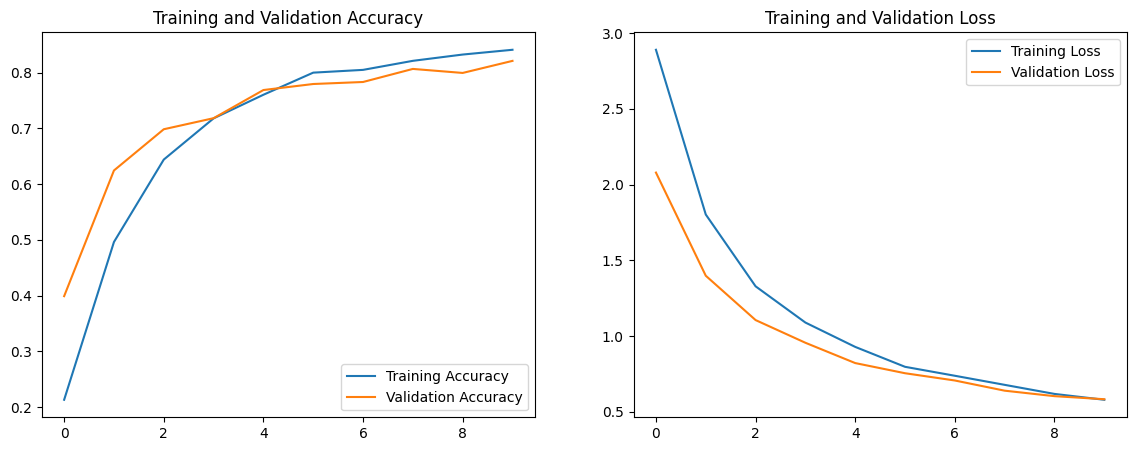

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


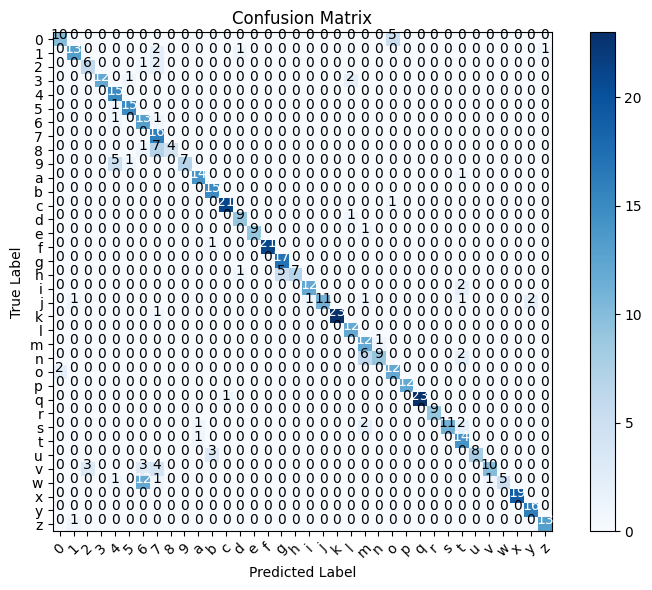

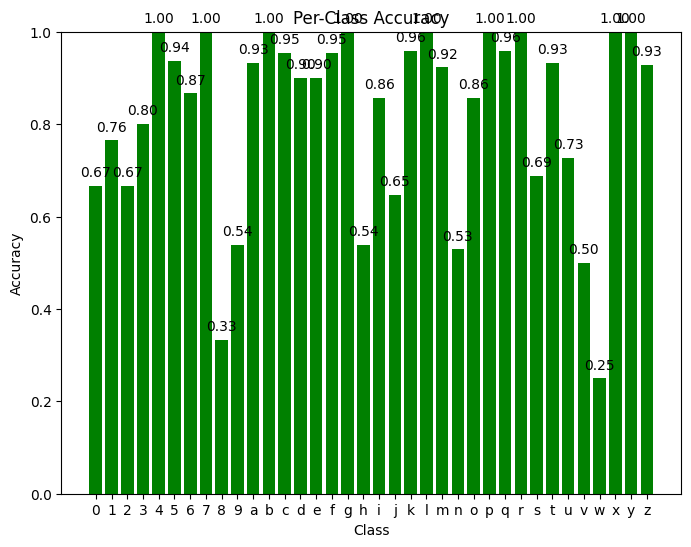

18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 446ms/step - accuracy: 0.8218 - loss: 0.5646
Validation Loss: 0.5828
Validation Accuracy: 0.8213
Model saved to asl_model_transfer.keras


In [15]:
import numpy as np
# ----- Plot Training Curves -----
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# ----- Additional Evaluation Graphs -----
all_preds = []
all_labels = []
for images, labels in val_ds:
    preds = model.predict(images)
    all_preds.extend(np.argmax(preds, axis=1))
    all_labels.extend(labels.numpy())
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Confusion Matrix
cm = tf.math.confusion_matrix(all_labels, all_preds).numpy()

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, format(cm[i, j], 'd'),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > cm.max()/2 else "black")
plt.tight_layout()
plt.show()

# Per-Class Accuracy Bar Chart
per_class_accuracy = []
for i in range(len(class_names)):
    class_total = np.sum(cm[i, :])
    acc_val = cm[i, i] / class_total if class_total > 0 else 0
    per_class_accuracy.append(acc_val)
plt.figure(figsize=(8, 6))
plt.bar(class_names, per_class_accuracy, color='green')
plt.title("Per-Class Accuracy")
plt.xlabel("Class")
plt.ylabel("Accuracy")
plt.ylim([0, 1])
for i, v in enumerate(per_class_accuracy):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center')
plt.show()

# Evaluate and save the model
val_loss, val_accuracy = model.evaluate(val_ds)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
model.save(model_save_path)
print(f"Model saved to {model_save_path}")

### Real-Time American Sign Language (ASL) Detection Using a Trained Model

This section of the code loads a pre-trained model and uses a webcam to detect hand gestures in real-time, identifying sign language gestures with MobileNetV2 and MediaPipe.

---

### 1. Loading the Pre-Trained Model and Class Names
- model = tf.keras.models.load_model(model_path): Loads the saved ASL classification model from the file asl_model_transfer.keras.
- class_names: Reads the class names from class_names.txt to map numerical predictions to sign labels.
- The model will use these class names to label detected hand signs.

---

### 2. Initializing the Webcam for Real-Time Capture
- cv2.VideoCapture(0): Opens the default webcam for capturing live video.
- If the webcam fails to open, an error message is displayed, and the script exits.

---

### 3. Using MediaPipe for Hand Detection
- mp.solutions.hands.Hands(): Initializes MediaPipe's hand tracking solution.
  - static_image_mode=False: Optimized for real-time video (not static images).
  - max_num_hands=1: Limits detection to one hand at a time.
  - min_detection_confidence=0.5: The model detects a hand only if confidence is above 50%.
  - min_tracking_confidence=0.5: Ensures smooth tracking of hand landmarks.
- The detected hand landmarks are drawn on the webcam feed using mp_drawing.draw_landmarks().

---

### 4. Hand Gesture Recognition and Preprocessing
- The detected hand bounding box is extracted from the frame.
- The cropped hand image is resized to 224x224 pixels, the input size required by MobileNetV2.
- The image is normalized using MobileNetV2’s preprocessing function to match the format used during training.
- The preprocessed image is passed into the model for prediction.

---

### 5. Making Predictions and Displaying Results
- The model predicts class probabilities for the captured hand sign.
- Confidence Thresholding (threshold=0.8):
  - If confidence is above 80%, the detected class is displayed.
  - If confidence is low, the detection is marked as uncertain.
- The top three predictions (highest probability classes) are printed for debugging.

---

### 6. Overlaying Results on the Video Feed
- The detected sign label and confidence score are displayed on the webcam feed.
- A buffer (text_buffer) stores detected words, allowing real-time sign language sentence formation.

---

### 7. Ending the Detection
- The detection runs in a loop until the user presses q.
- The webcam is released and the OpenCV window is closed.
- The final text buffer is printed, showing the sequence of detected signs.

---

### Summary
This real-time ASL recognition system:
- Detects hands using MediaPipe  
- Extracts and preprocesses hand images  
- Uses a MobileNetV2 model to classify hand gestures  
- Displays real-time results with OpenCV  
- Saves detected signs in a text buffer for potential sentence formation  

This setup allows users to interactively recognize and classify sign language gestures in real time.


In [ ]:
# ------------------ Testing (Real-Time Detection) Mode ------------------
import cv2
import tensorflow as tf
import mediapipe as mp
import sys
import numpy as np

model_path = "asl_model_transfer.keras"
class_names_path = "class_names.txt"
threshold = 0.8
img_size = (224, 224)

# Load model and class names
model = tf.keras.models.load_model(model_path)
with open(class_names_path, "r") as f:
    class_names = [line.strip() for line in f.readlines()]
print("Loaded class names:", class_names)


# Initialize webcam
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("Error: Could not open webcam.")
    sys.exit()

text_buffer = ""
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

with mp_hands.Hands(
    static_image_mode=False,
    max_num_hands=1,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
) as hands:
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Flip the frame horizontally
        frame = cv2.flip(frame, 1)
        h, w, _ = frame.shape

        # Process the frame with MediaPipe Hands
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = hands.process(rgb_frame)

        detection_text = "Detected: ???"
        hand_found = False

        if results.multi_hand_landmarks:
            hand_found = True
            for hand_landmarks in results.multi_hand_landmarks:
                mp_drawing.draw_landmarks(
                    frame,
                    hand_landmarks,
                    mp_hands.HAND_CONNECTIONS
                )
                x_min, x_max = w, 0
                y_min, y_max = h, 0
                for lm in hand_landmarks.landmark:
                    x, y = int(lm.x * w), int(lm.y * h)
                    if x < x_min: x_min = x
                    if x > x_max: x_max = x
                    if y < y_min: y_min = y
                    if y > y_max: y_max = y
                margin = 20
                x_min = max(0, x_min - margin)
                y_min = max(0, y_min - margin)
                x_max = min(w, x_max + margin)
                y_max = min(h, y_max + margin)
                hand_crop = frame[y_min:y_max, x_min:x_max]
                if hand_crop.size > 0:
                    hand_crop_resized = cv2.resize(hand_crop, img_size)
                    hand_crop_resized = hand_crop_resized.astype("float32")
                    hand_crop_resized = tf.keras.applications.mobilenet_v2.preprocess_input(
                        hand_crop_resized
                    )
                    hand_crop_resized = np.expand_dims(hand_crop_resized, axis=0)
                    preds = model.predict(hand_crop_resized)[0]
                    conf = np.max(preds)
                    pred_class = np.argmax(preds)
                    
                    # Debug: print top 3 predictions
                    sorted_idx = np.argsort(preds)[::-1]
                    top3 = sorted_idx[:3]
                    print("Prediction distribution (top 3):")
                    for i in top3:
                        print(f"  {class_names[i]}: {preds[i]*100:.2f}%")
                    print("-------------------------")
                    
                    if conf > threshold:
                        sign_label = class_names[pred_class]
                        detection_text = f"Detected: {sign_label} ({conf:.2f})"
                        text_buffer += sign_label
                    else:
                        sign_label = class_names[pred_class]
                        detection_text = f"Low confidence: {sign_label} ({conf:.2f})"

        cv2.putText(
            frame,
            detection_text,
            (10, 30),
            cv2.FONT_HERSHEY_SIMPLEX,
            1,
            (0, 255, 0) if hand_found else (0, 0, 255),
            2
        )
        cv2.putText(
            frame,
            f"Buffer: {text_buffer}",
            (10, 70),
            cv2.FONT_HERSHEY_SIMPLEX,
            1,
            (255, 255, 255),
            2
        )
        cv2.imshow("ASL Real-Time with MobileNet", frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()
print("Final text buffer:", text_buffer)